# Actividad 2: Convolutional Neural Networks

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [ ]:
import cv2
import os
import numpy as np 
import keras
from keras import layers
from keras import models
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import matplotlib.pyplot as plt
import glob
import random



# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10665984/10658925 [==============================] - 2s 0us/step


In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [ ]:
print('============ Dataset Split ============')
print('Entrenamiento:', X.shape)
print('Test:', X_t.shape)
print('=======================================')
print('')

============ Dataset Split ============
Entrenamiento: (18992, 64, 64, 3)
Test: (890, 64, 64, 3)



In [ ]:
def plot_data_analysis(numero_columnas, numero_clases, img, y, titulo):

    numero_muestras = []
    #  Configuración de las dimensiones del gráfico
    figura, axis = plt.subplots(nrows=numero_clases, ncols=numero_columnas,
                                figsize=(8, 25))
    figura.tight_layout()

    #  Bucle aninado, que recorre las columnas y las clases
    for i in range(numero_columnas):
        for j in range(numero_clases):
            #  Se eliguen las imagenes que pertenecen a una clase
            x = img[y == j] 

            #  Se representa una imagen aleatoriamente.
            axis[j][i].imshow(x[random.randint(0, len(x) - 1), :, :, ::-1])

            # Desactivar cuadricula
            axis[j][i].axis("off")

            #  Titulo de la clase en la 2 columna y se guarda el número de muestras
            #  de cada clase.
            if i == 2:
                axis[j][i].set_title(MAP_CHARACTERS[j])
                numero_muestras.append(sum(y == j))

    #  Configuración de las dimensiones del gráfico
    plt.figure(figsize=(25, 8))
    plt.bar(range(0, numero_clases), numero_muestras, width=0.7, color="blue")

    #  Creación de las barras del grafico, con el número de muestras por clase
    for i in range(0, numero_clases):
        plt.text(i, numero_muestras[i], str(numero_muestras[i]),
                horizontalalignment='center', fontsize=14)

    #  Configuración de la apariencia del gráfico.
    plt.tick_params(labelsize=14)
    plt.xticks(range(0, len(MAP_CHARACTERS)),[class_name for class_name in MAP_CHARACTERS.values()], rotation=90)
    plt.xlabel("Clases", fontsize=16)
    plt.ylabel("Nº de muestras", fontsize=16)
    plt.title(f"Frecuencia del conjunto {titulo}", fontsize=20)
    plt.show()

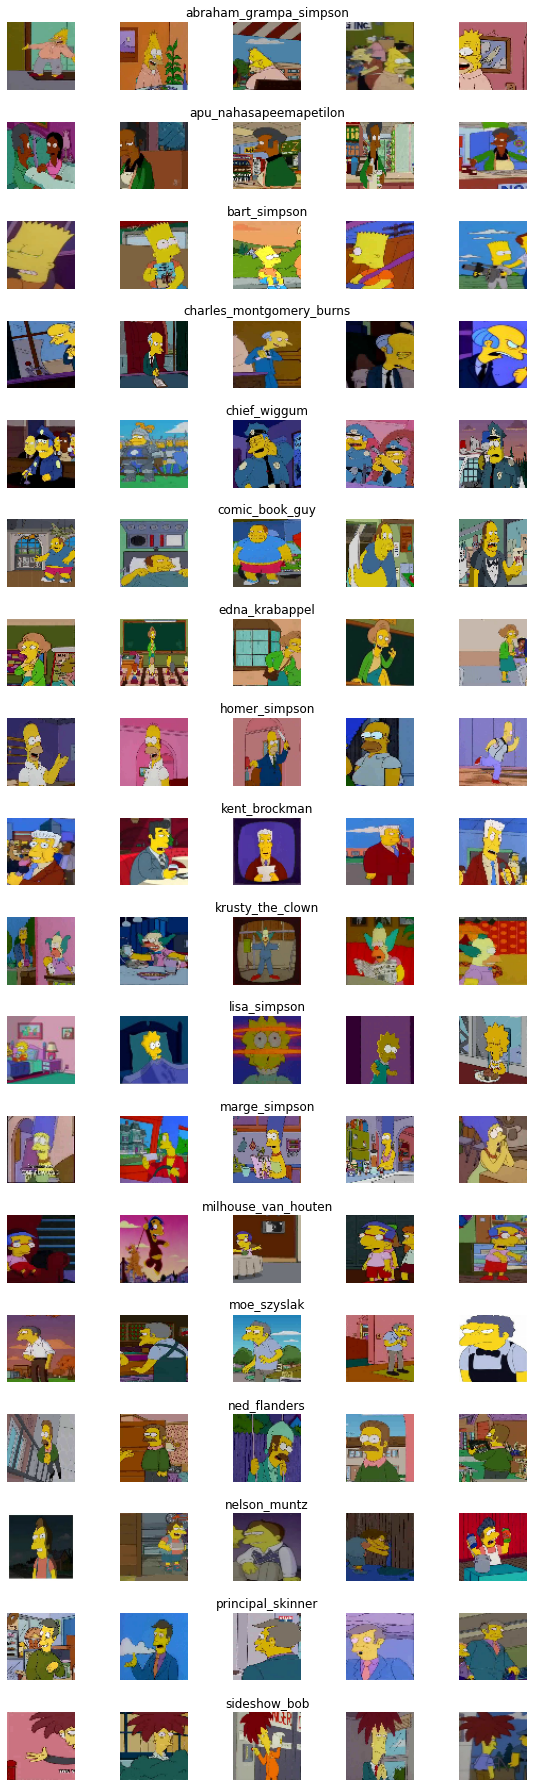

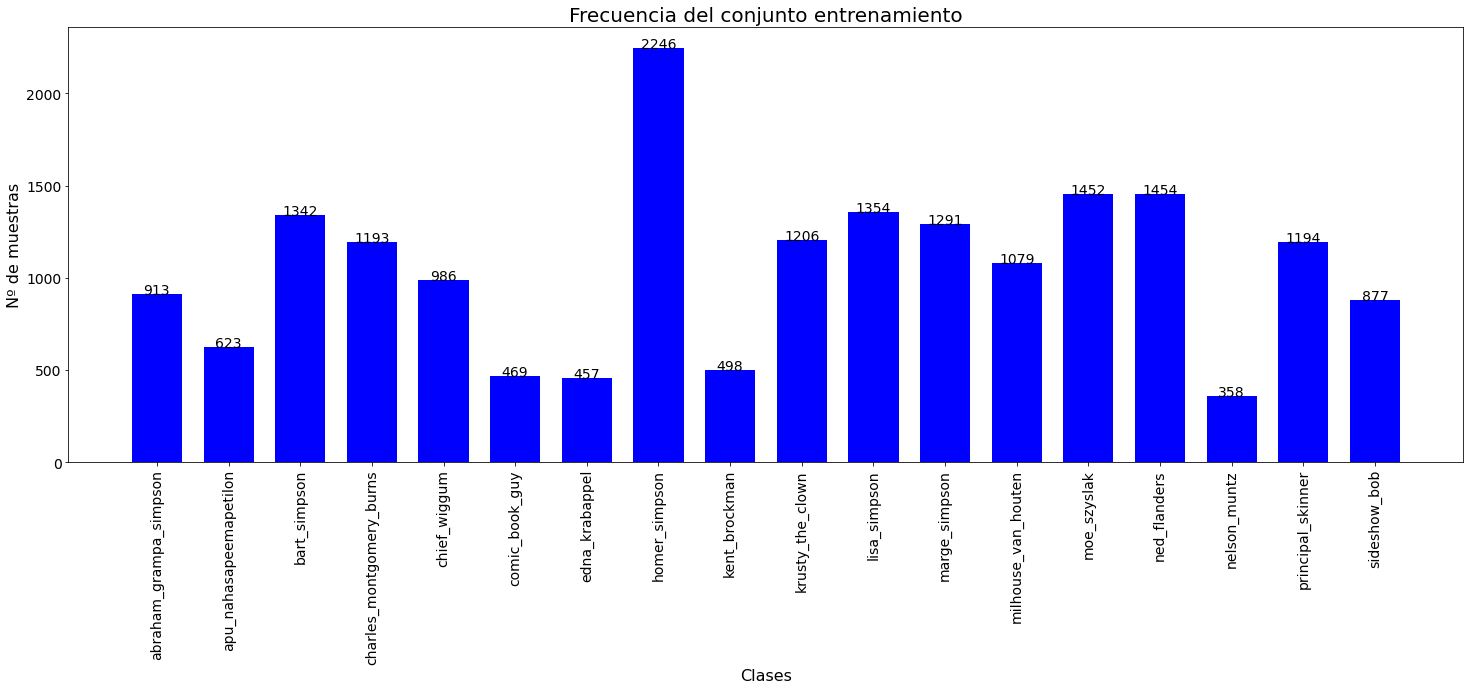

In [ ]:
plot_data_analysis(5, 18, X, y, 'entrenamiento')

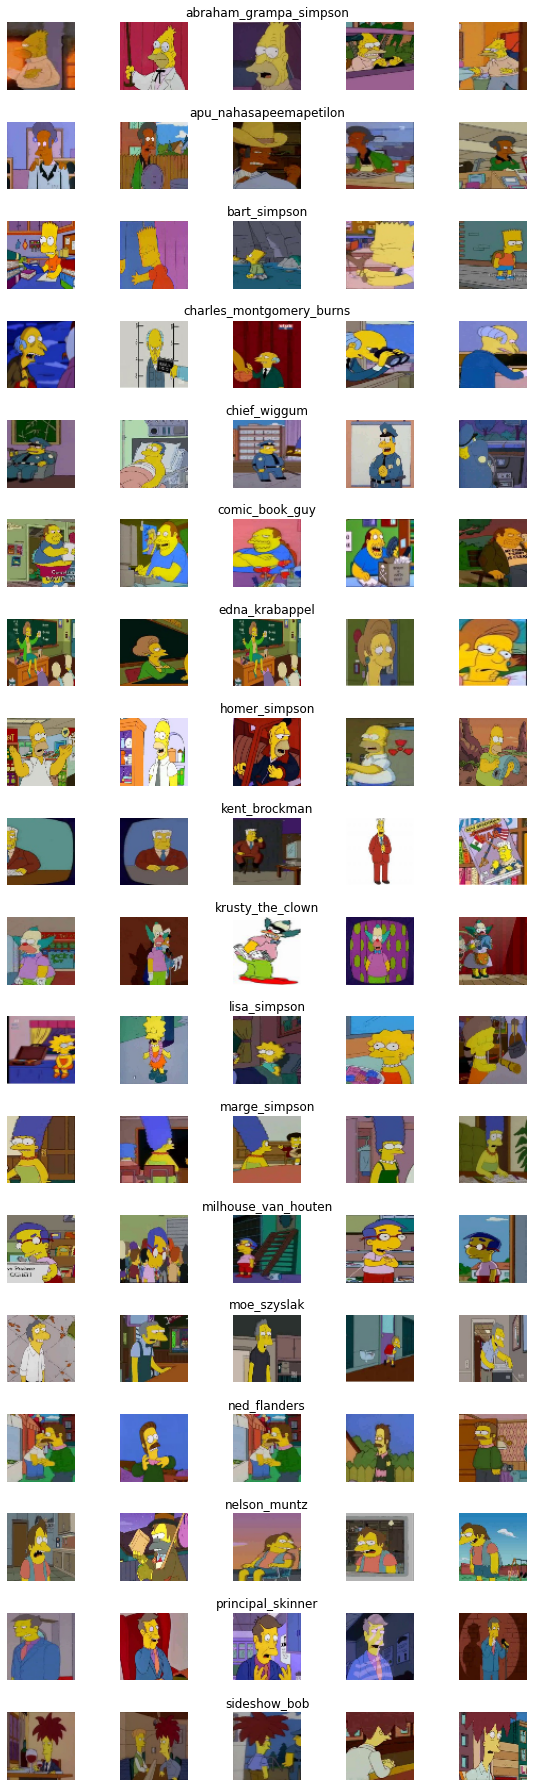

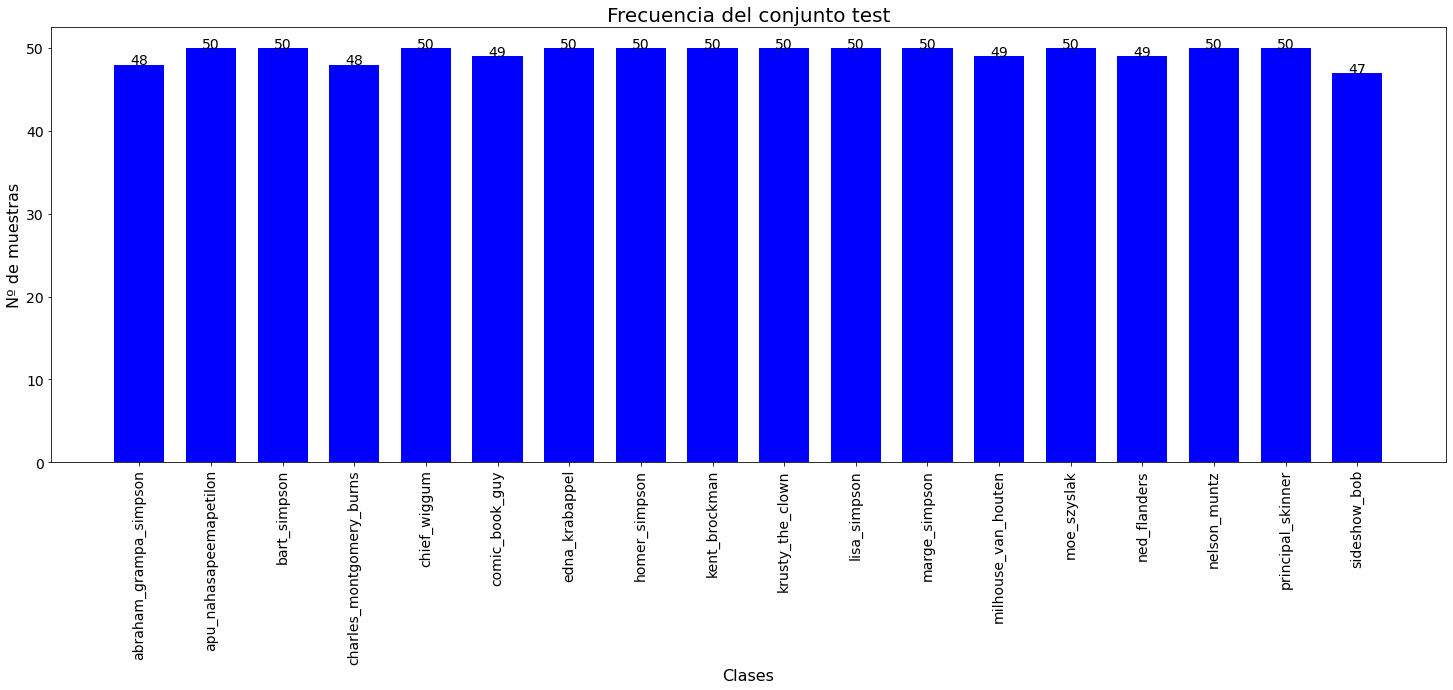

In [ ]:
plot_data_analysis(5, 18, X_t, y_t, 'test')

In [ ]:
#  Se normalizan las imagenes en un factor 1/255 y se convierten en tipo float
X = X.astype('float32') / 255

#  Se normalizan las imagenes en un factor 1/255 y se convierten en tipo float
X_t = X_t.astype('float32') / 255

#  Se codifican las etiquetas como one-hot enconding
y = to_categorical(y)
y_t = to_categorical(y_t)

In [ ]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

In [ ]:
model2 = models.Sequential()

#  Se añaden las capas al modelo

#  Bloque 1 CNN
model2.add(layers.Conv2D(32, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True,
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

#  Bloque 2 CNN
model2.add(layers.Conv2D(64, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

# Bloque 3 CNN
model2.add(layers.Conv2D(64, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

# Bloque 4 CNN
model2.add(layers.Conv2D(128, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.25))

# Bloque 5 CNN
model2.add(layers.Conv2D(254, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

#  Bloque 6 FC
model2.add(layers.Flatten())
model2.add(layers.Dense(254, activation=keras.layers.LeakyReLU(alpha=0.3)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.3)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(18, activation='softmax'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)       

In [ ]:
from keras.optimizers import RMSprop
model2.compile(optimizer=RMSprop(lr=0.001, decay=1e-6),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])
history = model2.fit(X,
                    y,
                    epochs = 60, 
                    batch_size=64,
                    validation_split=0.2)

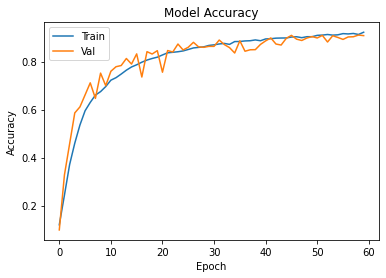

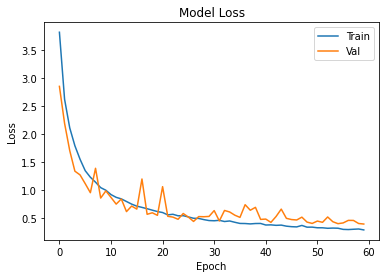

In [ ]:
plot_acc(history)
plot_loss(history)

In [ ]:
model2.evaluate(X_t, y_t)

28/28 [==============================] - 0s 9ms/step - loss: 0.2013 - accuracy: 0.9382


[0.20131349563598633, 0.9382022619247437]

In [ ]:
model = models.Sequential()

#  Se añaden las capas al modelo

#  Bloque 1 CNN
model.add(layers.Conv2D(32, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True,
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

#  Bloque 2 CNN
model.add(layers.Conv2D(64, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Bloque 3 CNN
model.add(layers.Conv2D(64, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Bloque 4 CNN
model.add(layers.Conv2D(128, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

# Bloque 5 CNN
model.add(layers.Conv2D(254, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

#  Bloque 6 FC
model.add(layers.Flatten())
model.add(layers.Dense(254, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(18, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

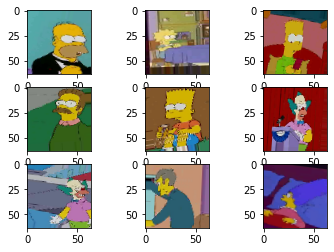

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
    
datagen.fit(X)

for x_batch, y_batch in datagen.flow(X, y, batch_size=9):
    for i in range(0, x_batch.shape[0]):
        plt.subplot(330 + 1 + i)
        plt.imshow((x_batch[i])[:, :, ::-1])
    plt.show()
    break

In [ ]:
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001, decay=1e-6),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [ ]:
epochs = 60 
batch_size = 64

history = model.fit_generator(datagen.flow(X,y, batch_size=batch_size, shuffle=True),
                              epochs = epochs, 
                              validation_data = (X,y),
                              steps_per_epoch=X.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
296/296 [==============================] - 60s 91ms/step - loss: 4.9168 - accuracy: 0.0919 - val_loss: 2.5785 - val_accuracy: 0.2458
Epoch 2/60
296/296 [==============================] - 26s 88ms/step - loss: 2.6777 - accuracy: 0.2117 - val_loss: 2.0356 - val_accuracy: 0.3894
Epoch 3/60
296/296 [==============================] - 26s 87ms/step - loss: 2.1620 - accuracy: 0.3472 - val_loss: 1.3837 - val_accuracy: 0.5729
Epoch 4/60
296/296 [==============================] - 26s 87ms/step - loss: 1.8169 - accuracy: 0.4460 - val_loss: 1.7462 - val_accuracy: 0.5726
Epoch 5/60
296/296 [==============================] - 25s 86ms/step - loss: 1.5524 - accuracy: 0.5259 - val_loss: 1.5298 - val_accuracy: 0.6193
Epoch 6/60
296/296 [==============================] - 25s 86ms/step - loss: 1.4083 - accuracy: 0.5669 - val_loss: 1.5730 - val_accuracy: 0.6301
Epoch 7/60
296/296 [==============================] - 26s 87ms/step - loss: 1.2810 - accuracy: 0.6099 - val_loss: 0.7845 - val_accuracy:

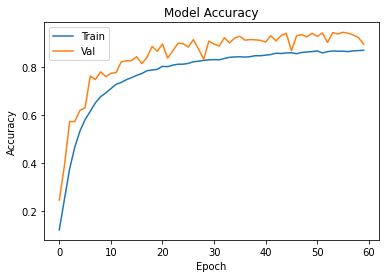

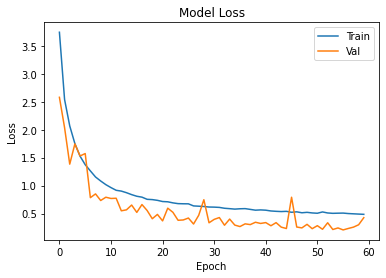

In [ ]:
plot_acc(history)
plot_loss(history)

In [ ]:
model.evaluate(X_t, y_t)

28/28 [==============================] - 0s 10ms/step - loss: 0.3139 - accuracy: 0.9180


[0.3139118552207947, 0.917977511882782]